In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "cell_images\\cell_images\\train"
test_path  = "cell_images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=128, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=128, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
ConvNeXtLarge_model = Sequential()

pretrained_model= tf.keras.applications.ConvNeXtLarge(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

ConvNeXtLarge_model.add(pretrained_model)

ConvNeXtLarge_model.add(Flatten())
ConvNeXtLarge_model.add(Dense(128, activation='relu'))
ConvNeXtLarge_model.add(Dense(1, activation='sigmoid'))

785596384/785596384 [==============================] - 93s 0us/step


In [11]:
ConvNeXtLarge_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_large (Functional)  (None, 1536)             196230336 
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 196,427,201
Trainable params: 196,865
Non-trainable params: 196,230,336
_________________________________________________________________


In [12]:
ConvNeXtLarge_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=12)

In [14]:
ConvNeXtLarge_model.fit(train_image_gen, epochs=60, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/60
195/195 [==============================] - 417s 2s/step - loss: 0.1989 - accuracy: 0.9234 - val_loss: 0.1773 - val_accuracy: 0.9331
Epoch 2/60
195/195 [==============================] - 197s 1s/step - loss: 0.1456 - accuracy: 0.9478 - val_loss: 0.1535 - val_accuracy: 0.9481
Epoch 3/60
195/195 [==============================] - 225s 1s/step - loss: 0.1343 - accuracy: 0.9502 - val_loss: 0.1500 - val_accuracy: 0.9450
Epoch 4/60
195/195 [==============================] - 426s 2s/step - loss: 0.1314 - accuracy: 0.9510 - val_loss: 0.1338 - val_accuracy: 0.9515
Epoch 5/60
195/195 [==============================] - 200s 1s/step - loss: 0.1265 - accuracy: 0.9536 - val_loss: 0.1453 - val_accuracy: 0.9415
Epoch 6/60
195/195 [==============================] - 201s 1s/step - loss: 0.1252 - accuracy: 0.9541 - val_loss: 0.1397 - val_accuracy: 0.9488
Epoch 7/60
195/195 [==============================] - 200s 1s/step - loss: 0.1255 - accuracy: 0.9548 - val_loss: 0.1438 - val_accuracy: 0.9473

In [15]:
history = pd.DataFrame(ConvNeXtLarge_model.history.history)

In [16]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.198875,0.923351,0.177308,0.933077
1,0.145571,0.947752,0.153513,0.948077
2,0.134326,0.950196,0.149954,0.945000
3,0.131394,0.950958,0.133809,0.951538
4,0.126542,0.953642,0.145315,0.941538


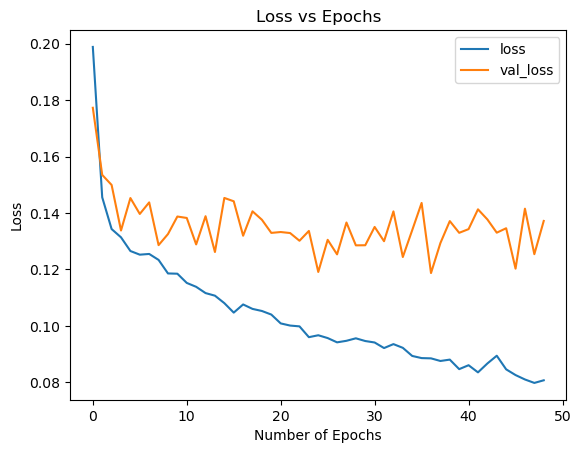

In [17]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsConNXtL.png')
plt.show()

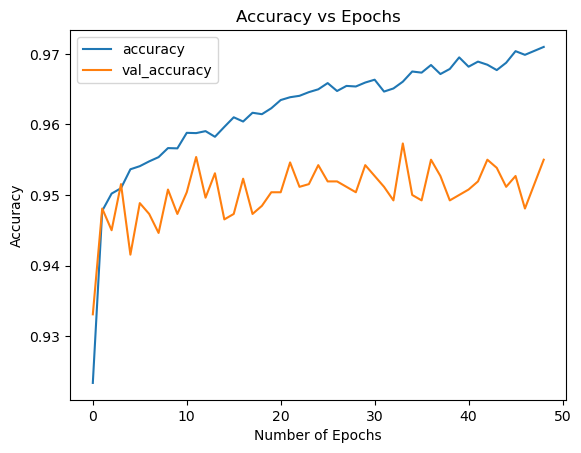

In [18]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsConNXtL.png')
plt.show()

In [19]:
predictions = ConvNeXtLarge_model.predict(test_image_gen)

21/21 [==============================] - 26s 846ms/step


In [20]:
predictions = predictions >= 0.5

In [21]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1300
           1       0.95      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [22]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1229,   71],
       [  52, 1248]], dtype=int64)

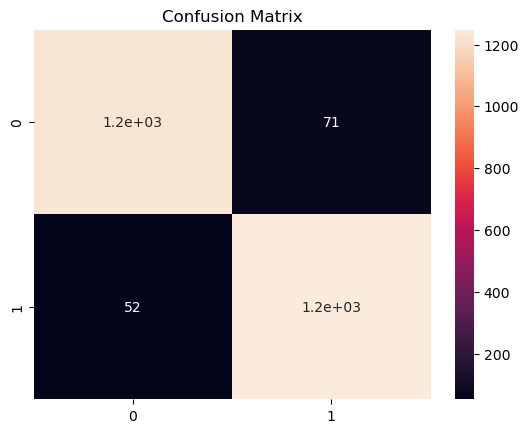

In [23]:
import seaborn as sns
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapConNXtL.png')
plt.show()

In [24]:
ConvNeXtLarge_model.save("MalariaPredictionsConNXtL.h5")